In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.metrics import classification_report, confusion_matrix

import os
from tqdm import tqdm

tqdm.pandas()

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eug\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eug\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

1. Превратить метку в число
2. Просмотр распределения данных (имбаланс или нет)
3. Просмотр распрделения длины токена
4. предварительный просмотр некоторых положительных и отрицательных отзывов

In [88]:
data = pd.read_csv("data/CNN_Articles.csv")
data.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


In [89]:
data = data[["Article text", "Category"]]
data

,Article text,Category
0,"(CNN)Right now, there's a shortage of truck d...",news
1,(CNN)Working in a factory or warehouse can me...,news
2,"(CNN)In a Hong Kong warehouse, a swarm of aut...",news
3,The pandemic thrust the working world into a n...,business
4,New York (CNN Business)March Madness isn't jus...,business
...,...,...
37944,(CNN)Russian President Vladimir Putin has bee...,sport
37945,"Lviv, Ukraine (CNN)A long line of men snakes o...",news
37946,(CNN)Major League Baseball (MLB) is postponin...,sport
37947,Here's a look at the life of Mikhail Gorbachev...,news


In [90]:
data["Category"].value_counts()

Category
news             18077
sport            15542
politics          2461
business           854
health             557
entertainment      413
travel              39
vr                   5
style                1
Name: count, dtype: int64

In [91]:
# X = data["Article text"]
y = data["Category"]

In [92]:
y.factorize()

(array([0, 0, 0, ..., 4, 0, 0], dtype=int64),
 Index(['news', 'business', 'health', 'entertainment', 'sport', 'politics',
        'travel', 'vr', 'style'],
       dtype='object'))

In [93]:
data["label"] = y.factorize()[0]

# Очистка и предобработка

1. Создадим пайплай очистки текста
2. Создадим пайплайн предварительной обработки текста
3. Сохраним предобработанные данные в виде нового CSV-файле.

In [81]:
# data.dropna(how='all', inplace=True)

In [97]:
data["Article text"][4506]

'\n\n\n'

In [98]:
data["text"] = data["Article text"].astype(str)

In [99]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    return re.sub (r'[\"\#\$\%\&\'\(\)\*\+\/\;\;\<\=\>\@\[\\\]\^\_\`\{\ /\}\~]', ' ', text)

def rm_html(text):
    return re.sub (r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r' ([.,!?-])'
    s = re.sub(pattern, r' \1', text)
    s = re.sub (r'\s{2,}', ' ', s)
    return s

def rm_number (text):
    return re.sub (r'\d+', '', text)

def rm_whitespaces (text):
    return re.sub (r' +', ' ', text)

def rm_nonascii(text):
    return re.sub (r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub (r' (.)\1+', r'\1\1', text)


def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji  = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [100]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stop_words]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains stopwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [101]:
data["clean"] = data["text"].progress_apply(clean_pipeline)
data["processed"] = data["clean"].progress_apply(preprocess_pipeline)
data.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37949/37949 [03:27<00:00, 182.62it/s]


,Article text,Category,label,text,clean,processed
0,"(CNN)Right now, there's a shortage of truck d...",news,0,"(CNN)Right now, there's a shortage of truck d...","CNN Right now, there s a shortage of truck dr...","CNN Right , shortage truck driver US worldwide..."
1,(CNN)Working in a factory or warehouse can me...,news,0,(CNN)Working in a factory or warehouse can me...,CNN Working in a factory or warehouse can mea...,"CNN Working factory warehouse mean task , repe..."
2,"(CNN)In a Hong Kong warehouse, a swarm of aut...",news,0,"(CNN)In a Hong Kong warehouse, a swarm of aut...","CNN In a Hong Kong warehouse, a swarm of auto...","CNN In Hong Kong warehouse , swarm autonomous ..."
3,The pandemic thrust the working world into a n...,business,1,The pandemic thrust the working world into a n...,The pandemic thrust the working world into a n...,The pandemic thrust working world new reality ...
4,New York (CNN Business)March Madness isn't jus...,business,1,New York (CNN Business)March Madness isn't jus...,New York CNN Business March Madness isn t just...,New York CNN Business March Madness college ba...


In [103]:
data.drop(data[data["processed"].str.len() < 10].index, inplace=True)

In [104]:
data.shape

(37916, 6)

In [105]:
data[["processed", "label"]].to_csv("./data/CNN_processed.csv", index=False, header=True)

# Подготовка датасета

К настоящему времени у нас уже есть обработанные даннеы. Прежде чем перейдем к этапу классификации, нам нужно преобразовать текст в векторыне представления (эмбеддинги). Для этого еам нужно создать словарь, который сопоставляет каждый токен с идентификаторами.

1. создадим словарь
2. закодируем отзывы
3. дополним короткие обзоры и обрежем длинные
4. разделим значения выборки на обучение / тест / валидацию
5. подготовим загрузчик данных и пакеты

In [2]:
data = pd.read_csv("./data/CNN_processed.csv")

for row in data[:1].iterrows():
    print(row[1]["processed"])
    print(f"Label: {row[1]["label"]}")
    print('\n')

CNN Right , shortage truck driver US worldwide , exacerbated e-commerce boom brought pandemic . One solution problem autonomous truck , several company race first launch one . Among San Diego-based TuSimple.Founded , TuSimple completed million mile road test prototype truck across US , China Europe . Although simply commercially available truck retrofitted technology , TuSimple deal place two world largest truck manufacturer -- Navistar US Traton , Volkswagen trucking business , Europe -- design build fully autonomous model , hope launch . Photos : The Yara Birkeland builder call world first zero-emission , autonomous cargo ship . The ship scheduled make first journey two Norwegian town end year . Click see form transport set transform future.Hide Caption Photos : Pictured rendering , Oceanbird wind-powered transatlantic car carrier cut carbon emission , compared standard car carrier.Hide Caption Photos : It maritime ship going green . Cities around world adopting electric ferry . Norw

In [3]:
data.drop(data[data.label == 8].index, inplace=True)

In [4]:
data.drop(data[data.label == 7].index, inplace=True)

In [5]:
data.drop(data[data.label == 6].index, inplace=True)

In [6]:
data.shape

(37871, 2)

In [7]:
num_features = len(data["label"].factorize()[1])
# y_label = np.eye(len(data["label"].factorize()[1]))[data["label"]]
# y_label.shape
num_features

6

In [8]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()

words[:10]

['CNN',
 'Right',
 ',',
 'shortage',
 'truck',
 'driver',
 'US',
 'worldwide',
 ',',
 'exacerbated']

In [9]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = "<PAD>"
word2int = {word: _id for _id, word in int2word.items()}

In [10]:
reviews[0]

'CNN Right , shortage truck driver US worldwide , exacerbated e-commerce boom brought pandemic . One solution problem autonomous truck , several company race first launch one . Among San Diego-based TuSimple.Founded , TuSimple completed million mile road test prototype truck across US , China Europe . Although simply commercially available truck retrofitted technology , TuSimple deal place two world largest truck manufacturer -- Navistar US Traton , Volkswagen trucking business , Europe -- design build fully autonomous model , hope launch . Photos : The Yara Birkeland builder call world first zero-emission , autonomous cargo ship . The ship scheduled make first journey two Norwegian town end year . Click see form transport set transform future.Hide Caption Photos : Pictured rendering , Oceanbird wind-powered transatlantic car carrier cut carbon emission , compared standard car carrier.Hide Caption Photos : It maritime ship going green . Cities around world adopting electric ferry . Nor

In [11]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

for i in range(5):
    print(reviews_enc[i][:5])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37871/37871 [00:04<00:00, 7717.97it/s]

[11, 3320, 1, 3416, 1362]
[11, 9107, 3254, 6425, 319]
[11, 38, 1139, 1171, 6425]
[4, 489, 9082, 369, 31]
[98, 311, 11, 2401, 127]


In [18]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_lenght < len(row) then reviews will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features


seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int["<PAD>"], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[   11,  3320,     1,  3416,  1362,   401,    47,  2634,     1,
         8491],
       [   11,  9107,  3254,  6425,   319,  2133,     1, 24937,   235,
         7633],
       [   11,    38,  1139,  1171,  6425,     1, 16868,  7615,  4993,
           93],
       [    4,   489,  9082,   369,    31,    42,  1454,   127,   358,
         1109],
       [   98,   311,    11,  2401,   127, 14855,  1519,  1854,   134,
            2],
       [   32,  1476,   300,    14,   838,    11,  2401,  2370,  5979,
         4156],
       [   98,   311,    11,  2401, 20840,    94,    31,   396,  1793,
        11031],
       [  109,   535,  6272,  2107,  1476,     2,    15,  2980,   968,
        14096],
       [   98,   311,    11,  2401, 23457,  3313,     3,  4328,  1449,
            1],
       [   98,   311,    11,  2401, 14935,   804,   417,  5424,   788,
           60]])

In [19]:
labels = data.label.to_numpy()
labels

array([0, 0, 0, ..., 4, 0, 0], dtype=int64)

In [21]:
train_size = .7
val_size = .5

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

print("Feature Shapes:")
print('=' * 15)
print(f"Train set: {train_x.shape}")
print(f"Validation set: {val_x.shape}")
print(f"Test set: {test_x.shape}")

Feature Shapes:
Train set: (26509, 256)
Validation set: (5681, 256)
Test set: (5681, 256)


In [22]:
train_y_label = np.eye(num_features)[train_y]
train_y_label.shape

(26509, 6)

In [25]:
batch_size = 128

trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y_label))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
validloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [26]:
dataiter = iter(trainloader)
x, y = next(dataiter)

print("Sample batch size: ", x.size())
print("Sample batch input: \n", x)
print()
print("Sample label size: ", y.size())
print("Sample label input: \n", y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[   152, 475526,  29077,  ...,   4186,  13481, 475536],
        [    11,     32,   2179,  ...,    734,    100,    457],
        [ 14737,  17185,      1,  ...,     55,    297,     57],
        ...,
        [    11,   7124,    675,  ...,  12468, 244385,    427],
        [    11,   2540,     85,  ...,   1556,      1,    981],
        [   586,     11,    301,  ...,   4687,     78,    297]],
       dtype=torch.int32)

Sample label size:  torch.Size([128, 6])
Sample label input: 
 tensor([[0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
     

# Моделирование

что будем делать:
1. Создадим архитектуру нейронной сети
2. Определим гипер параметры модели
3. Настроим конфигурации обучения
4. Напишем цикл обучения-проверки
5. Нарисуем график изменения Loss
6. Вывод на тестовом наборе
7. Метрики оценки

In [39]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):

        super(SentimentModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        self.batch_norm = nn.BatchNorm1d(hidden_size, momentum=0.1)
        self.dropout = nn.Dropout(0.2)
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ = self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.batch_norm(o)
        o = self.dropout(o)
        o = self.fc(o)

        # sigoid
        o = self.softmax(o)

        return o

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [41]:
vocab_size = len(word2int)
output_size = train_y_label.shape[1]
embedding_size = 256
hidden_size = 376
n_layers = 2
dropout = 0.2

model = SentimentModel(
    vocab_size,
    output_size,
    hidden_size,
    embedding_size,
    n_layers,
    dropout
)
print(model)

SentimentModel(
  (embedding): Embedding(580236, 256)
  (lstm): LSTM(256, 376, num_layers=2, batch_first=True, dropout=0.2)
  (batch_norm): BatchNorm1d(376, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=376, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


In [70]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters(), lr=lr) #, weight_decay=1.e-4)
grad_clip = 5
epochs = 8
print_every = 1
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "epochs": epochs
}
es_limit = 5

In [71]:
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc="Training", leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:
    # Training
    model.train()

    train_loss = 0
    train_acc = 0

    for id_, (feature, target) in enumerate(trainloader):
        epochloop.set_postfix_str(f"Training batch {id_}/{len(trainloader)}")

        feature, target = feature.to(device), target.to(device)

        optim.zero_grad()
        out = model(feature)
        
        predicted = torch.zeros_like(target, dtype=torch.int8, device=device)
        for i, to_label in enumerate(out):
            max_index = torch.argmax(to_label)
            # Set the element at the maximum index to 1
            predicted[i, max_index] = 1
            
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optim.step()

        del feature, target, predicted

    history["train_loss"].append(train_loss / len(trainloader))
    history["train_acc"].append(train_acc / len(trainloader))

    # Validation
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id_, (feature, target) in enumerate(validloader):
            epochloop.set_postfix_str(f"Validation batch {id_}/{len(validloader)}")

            feature, target = feature.to(device), target.to(device)
            out = model(feature)

            predicted = torch.zeros_like(target, device=device)
            for i, to_label in enumerate(out):
                predicted[i] = torch.argmax(to_label)
            
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            loss = criterion(out.squeeze(), target.long())
            val_loss += loss.item()

            del feature, target, predicted


    history["val_loss"].append(val_loss / len(validloader))
    history["val_acc"].append(val_acc / len(validloader))


    # Возвращаем модель в режим обучения
    model.train()

    info_str = f"Val Loss: {val_loss / len(validloader):.3f} "
    info_str += f"| Val Acc: {val_acc / len(validloader):.3f}"
    epochloop.set_postfix_str(info_str)

    if (e + 1) % print_every == 0:
        info_str = f"Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} "
        info_str += f"Train Acc: {train_acc / len(trainloader):.3f} "
        info_str += f"| Val Loss: {val_loss / len(validloader):.3f} "
        info_str += f"Val Acc: {val_acc / len(validloader):.3f}"

        epochloop.write(info_str)
        epochloop.update()

    if val_loss / len(validloader) <= val_loss_min:
        torch.save(model.state_dict(), "./sentiment_lstm.pt")
        val_loss_min = val_loss / len(validloader)
        es_trigger = 0
    else:
        info_str = "[WARNING] Validation loss did not improved ("
        info_str += f"{val_loss_min:.3f} --> {val_loss / len(validloader):.3f})"

        epochloop.write(info_str)
        es_trigger += 1

    if es_trigger >= es_limit:
        epochloop.write(f"Early stopped at Epoch {e+1}")
        history["epochs"] = e + 1
        break

Training:  12%|██████████████▍                                                                                                    | 1/8 [00:31<03:42, 31.77s/it, Val Loss: 1.097 | Val Acc: 0.946]

Epoch 1/8 | Train Loss: 1.088 Train Acc: 0.985 | Val Loss: 1.097 Val Acc: 0.946


Training:  38%|███████████████████████████████████████████▏                                                                       | 3/8 [01:07<01:53, 22.78s/it, Val Loss: 1.087 | Val Acc: 0.956]

Epoch 2/8 | Train Loss: 1.084 Train Acc: 0.986 | Val Loss: 1.087 Val Acc: 0.956


Training:  62%|███████████████████████████████████████████████████████████████████████████████▍                                               | 5/8 [01:36<01:15, 25.10s/it, Training batch 2/208]

Epoch 3/8 | Train Loss: 1.081 Train Acc: 0.987 | Val Loss: 1.106 Val Acc: 0.937
[WARNING] Validation loss did not improved (1.087 --> 1.106)


Training:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 6/8 [02:00<00:36, 18.14s/it, Training batch 2/208]

Epoch 4/8 | Train Loss: 1.080 Train Acc: 0.988 | Val Loss: 1.106 Val Acc: 0.936
[WARNING] Validation loss did not improved (1.087 --> 1.106)


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:24<00:00, 19.77s/it, Training batch 2/208]

Epoch 5/8 | Train Loss: 1.077 Train Acc: 0.989 | Val Loss: 1.092 Val Acc: 0.952
[WARNING] Validation loss did not improved (1.087 --> 1.092)


Training: 9it [02:48, 16.34s/it, Training batch 2/208]                                                                                                                                            

Epoch 6/8 | Train Loss: 1.075 Train Acc: 0.990 | Val Loss: 1.120 Val Acc: 0.923
[WARNING] Validation loss did not improved (1.087 --> 1.120)


Training:  75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 6/8 [03:12<01:04, 32.02s/it, Val Loss: 1.094 | Val Acc: 0.949]

Epoch 7/8 | Train Loss: 1.073 Train Acc: 0.990 | Val Loss: 1.094 Val Acc: 0.949
[WARNING] Validation loss did not improved (1.087 --> 1.094)
Early stopped at Epoch 7


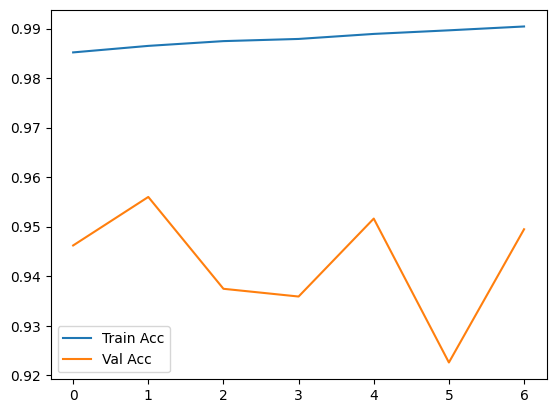

In [72]:
plt.figure.Figure(figsize=(6, 6))
plt.pyplot.plot(range(history["epochs"]), history["train_acc"], label="Train Acc")
plt.pyplot.plot(range(history["epochs"]), history["val_acc"], label="Val Acc")
plt.pyplot.legend()
plt.pyplot.show()

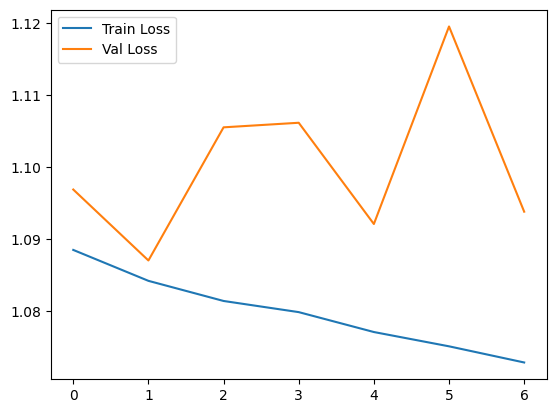

In [73]:
plt.figure.Figure(figsize=(6, 6))
plt.pyplot.plot(range(history["epochs"]), history["train_loss"], label="Train Loss")
plt.pyplot.plot(range(history["epochs"]), history["val_loss"], label="Val Loss")
plt.pyplot.legend()
plt.pyplot.show()

In [75]:
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc="Inference")
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.zeros_like(target, device=device)
        for i, to_label in enumerate(out):
            predicted[i] = torch.argmax(to_label)
        
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.long())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())


print(f"Accuracy {test_acc / len(testloader):.4f}, Loss: {test_loss / len(testloader):.4f}")

Inference: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 39.42it/s]

Accuracy 0.9369, Loss: 1.1063


# Оценка качества

In [78]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2368
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        88
           3       0.00      0.00      0.00        48
           4       0.92      1.00      0.95      3095
           5       0.00      0.00      0.00        47

    accuracy                           0.94      5681
   macro avg       0.31      0.32      0.32      5681
weighted avg       0.90      0.94      0.92      5681



D:\development\python\tasks_neiro_basics_arthur\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\development\python\tasks_neiro_basics_arthur\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\development\python\tasks_neiro_basics_arthur\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

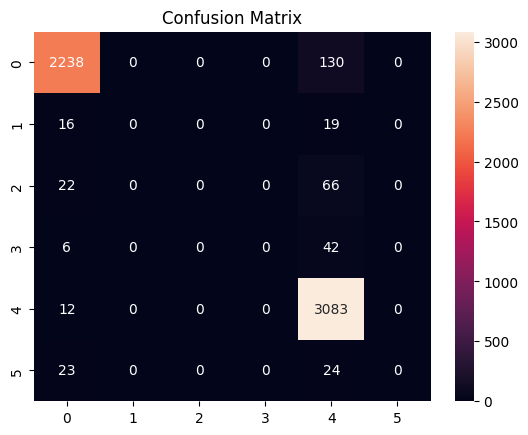

In [77]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure.Figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.pyplot.title("Confusion Matrix")
plt.pyplot.show()